In [1]:
!pip install seaborn

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bisect import bisect
import seaborn as sns
from tqdm import tqdm

from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

In [3]:
client = DandiAPIClient()

dandisets = list(client.get_dandisets())

neurodata_type_map = dict(
    ecephys=["LFP", "Units", "ElectricalSeries"],
    ophys=["PlaneSegmentation", "TwoPhotonSeries", "ImageSegmentation"],
    icephys=[
        "PatchClampSeries",
        "VoltageClampSeries",
        "CurrentClampSeries",
        "CurrentClampStimulusSeries",
    ],
)

def is_nwb(metadata):
    return any(
        x['identifier'] == 'RRID:SCR_015242'
        for x in metadata['assetsSummary'].get('dataStandard', {})
    )

def has_related_publication(metadata):
    return "relatedResource" in metadata and any(x.get("relation") == "dcite:IsDescribedBy" for x in metadata["relatedResource"])

data = defaultdict(list)
for dandiset in tqdm(dandisets):
    dandiset = dandiset.for_version("draft")
    identifier = dandiset.identifier
    metadata = dandiset.get_raw_metadata()
    
    if not is_nwb(metadata) or not dandiset.draft_version.size:
        continue
    data["identifier"].append(identifier)
    data["created"].append(dandiset.created)
    data["modified"].append(dandiset.modified)
    data["size"].append(dandiset.draft_version.size)
    if "species" in metadata["assetsSummary"] and len(metadata["assetsSummary"]["species"]):
        data["species"].append(metadata["assetsSummary"]["species"][0]["name"])
    else:
        data["species"].append(np.nan)
        
    data["nauthors"].append(
        sum(x.get('schemaKey',[]) == "Person" for x in metadata["contributor"]) if "contributor" in metadata else 0
    )
    
    
    for modality, ndtypes in neurodata_type_map.items():
        data[modality].append(
            any(x in ndtypes for x in metadata["assetsSummary"]["variableMeasured"])
        )
    
    data["numberOfSubjects"].append(metadata["assetsSummary"].get("numberOfSubjects", np.nan))
    data["numberOfFiles"].append(metadata["assetsSummary"].get("numberOfFiles", np.nan))        
    data["has_related_pub"].append(has_related_publication(metadata))
    
df = pd.DataFrame.from_dict(data)

A newer version (0.62.4) of dandi/dandi-cli is available. You are using 0.60.0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 476/476 [01:55<00:00,  4.12it/s]


In [4]:
species_replacement = {
    "Mus musculus - House mouse": "House mouse",
    "Rattus norvegicus - Norway rat": "Rat",
    "Brown rat": "Rat",
    "Rat; norway rat; rats; brown rat": "Rat",
    "Homo sapiens - Human": "Human",
    "Drosophila melanogaster - Fruit fly": "Fruit fly",
    "Danio rerio - Leopard danio": "Zebrafish",
    "Macaca mulatta - Rhesus monkey": "Rhesus monkey",
    "Danio rerio - Zebra fish": "Zebrafish",
    "Macaca nemestrina - Pig-tailed macaque": "Pig-tailed macaque",
    "Cricetulus griseus - Cricetulus aureus": "Chinese hamster",
    "Caenorhabditis elegans": "C. elegans",
    "Canis lupus familiaris - Dog": "Dog",
    "Oryctolagus cuniculus - Rabbits": "Rabbit",
    "Bos taurus - Cattle": "Cattle",
    "Macaca nemestrina - Pigtail macaque": "Pigtail macaque",
    "Ooceraea biroi - Clonal raider ant": "Clonal raider ant",
}

for key, val in species_replacement.items():
    df["species"] = df["species"].replace(key, val)

df

,identifier,created,modified,size,species,nauthors,ecephys,ophys,icephys,numberOfSubjects,numberOfFiles,has_related_pub
0,000003,2020-03-15 22:56:55.655000+00:00,2020-11-06 17:20:30.673000+00:00,2559248010229,House mouse,3,True,False,False,16.0,101,True
1,000004,2020-03-16 21:48:04.265000+00:00,2020-10-03 07:01:25.356000+00:00,6197474020,Human,13,True,False,False,59.0,87,True
2,000005,2020-03-16 22:52:44.757000+00:00,2020-04-09 20:59:35.377000+00:00,46436686324,House mouse,4,True,False,True,55.0,148,True
3,000006,2020-03-17 13:30:38.667000+00:00,2020-04-09 21:00:01.759000+00:00,139600500,House mouse,2,True,False,False,12.0,53,True
4,000007,2020-03-17 15:01:40.811000+00:00,2022-11-22 00:21:36.001459+00:00,199439472,House mouse,8,True,False,False,13.0,54,True
...,...,...,...,...,...,...,...,...,...,...,...,...
278,001073,2024-06-21 22:02:41.624982+00:00,2024-06-21 22:02:41.625001+00:00,495900228,Rat,1,True,False,False,3.0,3,False
279,001076,2024-06-27 18:30:30.864999+00:00,2024-06-27 18:30:51.854803+00:00,660278264,Zebrafish,1,False,True,False,1.0,44,False
280,001078,2024-07-01 11:09:01.762621+00:00,2024-07-01 11:09:01.762639+00:00,5683760829,Rhesus monkey,2,False,False,False,2.0,9,False
281,001084,2024-07-09 09:02:04.023305+00:00,2024-07-15 13:46:28.745018+00:00,32730793664,House mouse,16,False,True,False,2.0,3,True


In [35]:
df["species"].unique()

array(['House mouse', 'Human', nan, 'Rat', 'Rhesus monkey', 'Fruit fly',
       'Zebrafish', 'Pig-tailed macaque', 'Chinese hamster', 'Dog',
       'Clonal raider ant', 'C. elegans', 'Rabbit', 'Cattle',
       'Pigtail macaque', 'Procambarus clarkii - Red swamp crayfish',
       'Macaca nemestrina', 'Macaca fascicularis - Cynomolgus monkeys',
       'Sus scrofa domesticus - Domestic pig', 'Unidentified',
       'Taeniopygia guttata - Zebra finch',
       'Callithrix jacchus - Common marmoset'], dtype=object)

In [36]:
df["species"].value_counts()

species
House mouse                                 117
Rat                                          42
Human                                        37
Rhesus monkey                                25
Fruit fly                                    10
Cattle                                        9
C. elegans                                    7
Zebrafish                                     6
Chinese hamster                               4
Macaca nemestrina                             3
Clonal raider ant                             2
Rabbit                                        2
Unidentified                                  2
Dog                                           1
Pig-tailed macaque                            1
Pigtail macaque                               1
Procambarus clarkii - Red swamp crayfish      1
Macaca fascicularis - Cynomolgus monkeys      1
Sus scrofa domesticus - Domestic pig          1
Taeniopygia guttata - Zebra finch             1
Callithrix jacchus - Common marm

In [37]:
df["species"].value_counts().keys()

Index(['House mouse', 'Rat', 'Human', 'Rhesus monkey', 'Fruit fly', 'Cattle',
       'C. elegans', 'Zebrafish', 'Chinese hamster', 'Macaca nemestrina',
       'Clonal raider ant', 'Rabbit', 'Unidentified', 'Dog',
       'Pig-tailed macaque', 'Pigtail macaque',
       'Procambarus clarkii - Red swamp crayfish',
       'Macaca fascicularis - Cynomolgus monkeys',
       'Sus scrofa domesticus - Domestic pig',
       'Taeniopygia guttata - Zebra finch',
       'Callithrix jacchus - Common marmoset'],
      dtype='object', name='species')

Procambarus clarkii - Red swamp crayfish
Macaca fascicularis - Cynomolgus monkeys
Sus scrofa domesticus - Domestic pig
Taeniopygia guttata - Zebra finch
Callithrix jacchus - Common marmoset


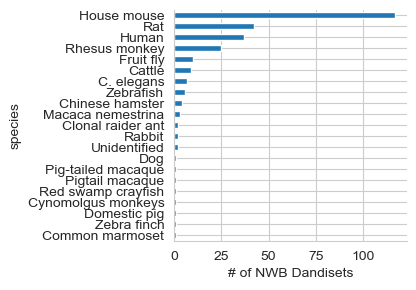

In [38]:
sns.set_style("whitegrid")
vals = df["species"]
# Only show short-hand label. E.g. ,replace "Procambarus clarkii - Red swamp crayfish" with "Red swamp crayfish"
for name in df["species"].value_counts().keys():
    if " - " in name:
        print(name)
        vals = vals.replace(name, name.split(" - ")[1]) 

ax = vals.value_counts().plot.barh(figsize=(3, 3))
ax.invert_yaxis()
ax.set_xlabel("# of NWB Dandisets")
ax.set_ylabel("species")
sns.despine()
ax.figure.savefig(
    "species.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


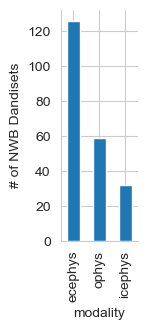

In [39]:
fig, ax = plt.subplots(figsize=(1, 3))

df[["ecephys", "ophys", "icephys"]].sum().plot.bar(ax=ax)
ax.set_xlabel("modality")
ax.set_ylabel("# of NWB Dandisets")
sns.despine()
ax.figure.savefig(
    "modality.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

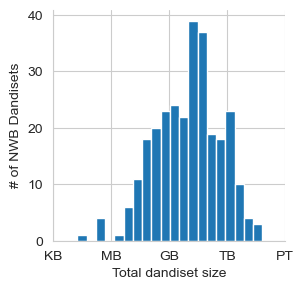

In [40]:
logsize = np.log10(df["size"])
#logsize[logsize < 0] = np.nan

fig, ax = plt.subplots(figsize=(3, 3))
ax = logsize.plot.hist(bins=20, ax=ax)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_xticklabels(["KB", "MB", "GB", "TB", "PT"])
ax.set_xlabel("Total dandiset size")
ax.set_ylabel("# of NWB Dandisets")
sns.despine()
ax.figure.savefig(
    "size.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [41]:
df["size"].sum()/(1e12)  #TB

302.977792275782

In [42]:
df["size"].sum()

302977792275782

In [43]:
len(df)

283

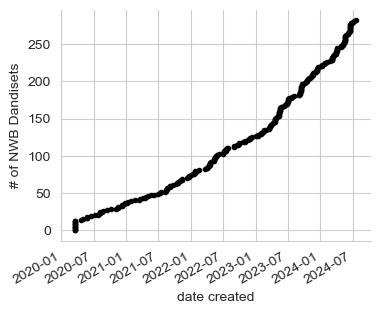

In [44]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(df['created'], np.arange(len(df)), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel('# of NWB Dandisets')
ax.set_xlabel("date created")
sns.despine()
ax.figure.savefig("date.png", bbox_inches="tight", dpi=300, transparent=True)

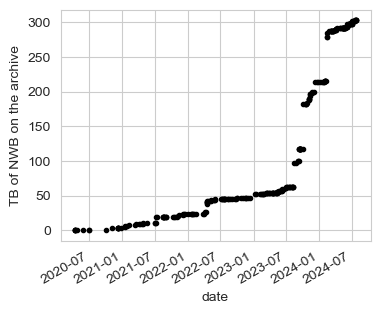

In [45]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], df['size'][order].cumsum()/10**12, '.k')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_xlabel("date")
_ = ax.set_ylabel("TB of NWB on the archive")

In [46]:
df.columns

Index(['identifier', 'created', 'modified', 'size', 'species', 'nauthors',
       'ecephys', 'ophys', 'icephys', 'numberOfSubjects', 'numberOfFiles',
       'has_related_pub'],
      dtype='object')

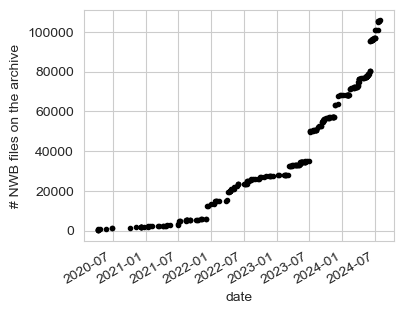

In [47]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], df['numberOfFiles'][order].cumsum(), '.k')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_xlabel("date")
_ = ax.set_ylabel("# NWB files on the archive")

[Text(0, 9, 'GB'), Text(0, 12, 'TB'), Text(0, 15, 'PB')]

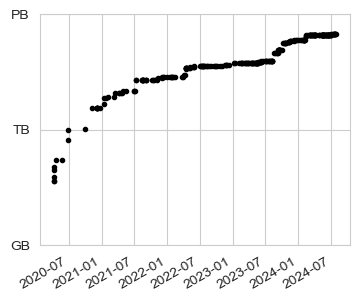

In [48]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], np.log10(df['size'][order].cumsum()), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_yticks([9,12,15])
ax.set_yticklabels(["GB", "TB", "PB"])

(12.0, 15.0)

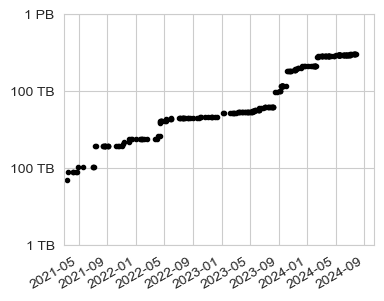

In [49]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], np.log10(df['size'][order].cumsum()), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_yticks([12, 13, 14, 15])
ax.set_yticklabels(["1 TB", "100 TB", "100 TB", "1 PB"])
ax.set_xlim(datetime(2021, 3, 1), None)
ax.set_ylim(12, 15)

In [50]:
date_idx = df['modified'][order].apply(lambda x: pd.to_datetime(x)).dt.date > datetime(2021,3,1).date()

In [51]:
seconds_in_a_day = 86400
days = (df['modified'][order]).apply(lambda x: (x.replace(tzinfo=None) - datetime(2021,3,1)).total_seconds()/seconds_in_a_day/365.25)

Text(0.5, 0, 'date')

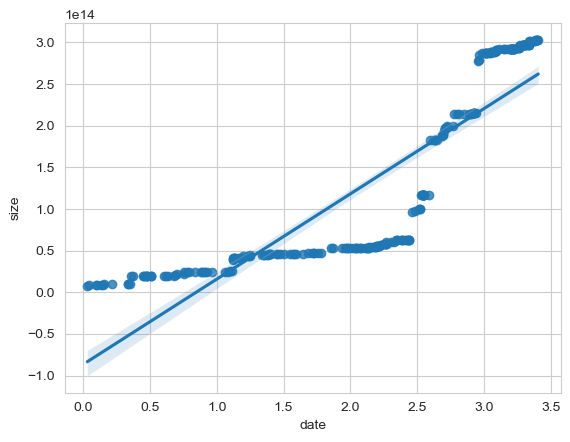

In [52]:
ax = sns.regplot(x=days[date_idx], y=df['size'][order].cumsum()[date_idx]);
ax.set_xlabel("date")
#ax.set_yticks([13, 14, 15])
#ax.set_yticklabels(["10 TB", "100 TB", "1 PB"])
#ax.set_yticks(12+np.log10(np.linspace(1,10,10)), minor=True)



Text(0, 0.5, 'total size (TB)')

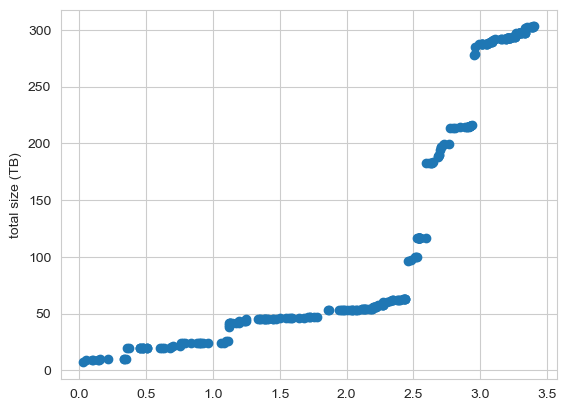

In [53]:
fig, ax = plt.subplots()
ax.plot(days[date_idx], df['size'][order].cumsum()[date_idx]/10**12, 'o')
ax.set_ylabel("total size (TB)")

(0.0, 3.0)

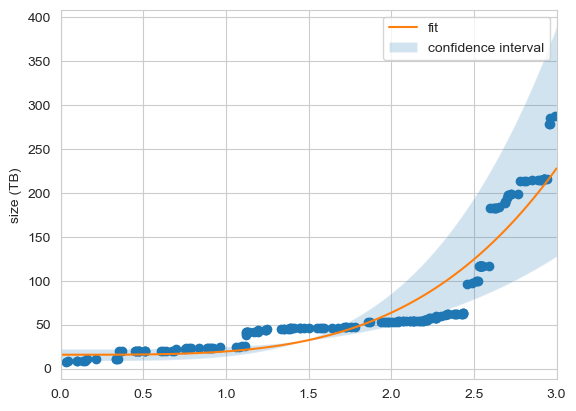

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, ax = plt.subplots()


# define the power-law function to fit
def power_law_func(x, a, b, c):
    return a * x**b - c

popt, pcov = curve_fit(power_law_func, days[date_idx], df['size'][order].cumsum()[date_idx]/10**12)

# calculate the confidence intervals
perr = np.sqrt(np.diag(pcov))
confidence_interval = 1.96 * perr
lower_bound = popt - confidence_interval
upper_bound = popt + confidence_interval

# plot the result
x = np.linspace(0, 3, 100)
ax.plot(days[date_idx], df['size'][order].cumsum()[date_idx]/10**12, 'o')
ax.plot(x, power_law_func(x, *popt), label='fit')
ax.fill_between(x, power_law_func(x, *lower_bound), power_law_func(x, *upper_bound), alpha=0.2, label='confidence interval')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
ax.set_ylabel("size (TB)")
ax.set_xlim(0,3)


In [55]:
12+np.log10(np.linspace(1,10,10))

array([12.        , 12.30103   , 12.47712125, 12.60205999, 12.69897   ,
       12.77815125, 12.84509804, 12.90308999, 12.95424251, 13.        ])

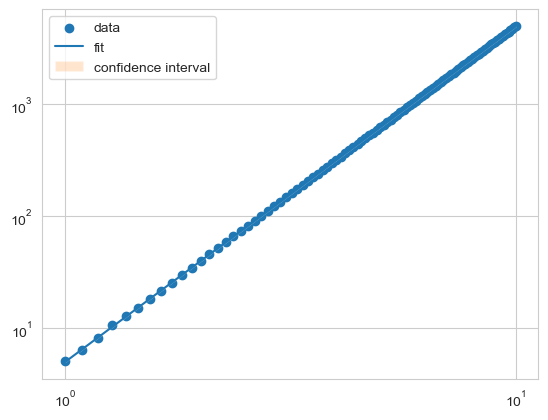

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# define the power-law function to fit
def power_law_func(x, a, b):
    return a * x**b

# generate some sample data
x = np.linspace(1, 10, 100)
y = 5 * x**(3) + np.random.normal(0, 0.2, size=len(x))

# fit the power-law function to the data
popt, pcov = curve_fit(power_law_func, x, y)

# calculate the confidence intervals
perr = np.sqrt(np.diag(pcov))
confidence_interval = 1.96 * perr
lower_bound = popt - confidence_interval
upper_bound = popt + confidence_interval

# plot the result
plt.scatter(x, y, label='data')
plt.plot(x, power_law_func(x, *popt), label='fit')
plt.fill_between(x, power_law_func(x, *lower_bound), power_law_func(x, *upper_bound), alpha=0.2, label='confidence interval')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [57]:
times = df['modified'][order]
days = (times - times.iloc[0]).apply(lambda x: x.total_seconds()/86400)

In [58]:
import scipy

x = days
y = df['size'][order].cumsum()

coefs, _ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y)


/Users/oruebel/miniforge3/envs/py4nwb/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/oruebel/miniforge3/envs/py4nwb/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:966: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/Users/oruebel/miniforge3/envs/py4nwb/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [59]:
coefs

array([1., 1.])

In [60]:
[1000**x for x in range(2,6)]
["MB", "GB", "TB", "PB"]

['MB', 'GB', 'TB', 'PB']

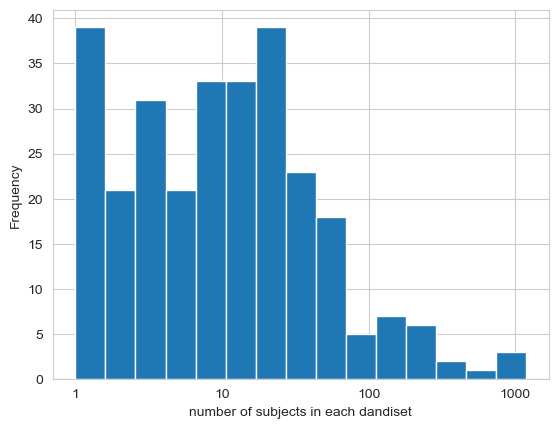

In [31]:
lognum = np.log10(df["numberOfSubjects"])


ax = lognum.plot.hist(bins=15)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_xlabel("number of subjects in each dandiset")
ax.figure.savefig("subjects.svg", bbox_inches="tight")

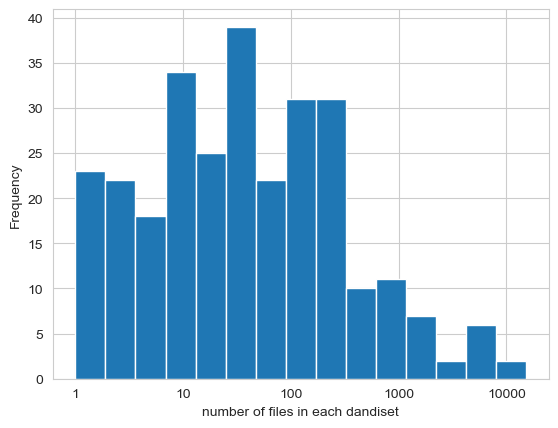

In [32]:
lognum = np.log10(df["numberOfFiles"])


ax = lognum.plot.hist(bins=15)
orders = np.arange(5)
ax.set_xticks(orders)
ax.set_xticklabels([10**x for x in orders])
ax.set_xlabel("number of files in each dandiset")
ax.figure.savefig("files.svg", bbox_inches="tight")

In [33]:
identifiers = df[
    (df["species"] == "House mouse") & 
    (df["numberOfSubjects"] > 40) & 
    (df["ecephys"] == True)
]["identifier"].values

In [34]:
# find only NWB files with male subjects

asset_list = []
for dandiset in dandisets:
    if dandiset.identifier not in identifiers:
        continue
    for asset in tqdm(list(dandiset.get_assets())):
        asset_metadata = asset.get_metadata()
        sex = asset_metadata.wasAttributedTo[0].sex
        if sex and sex.name == "Male":
            asset_list.append(asset)

  0%|                                                                                                                                                                            | 0/1576 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [ ]:
len(asset_list)

In [ ]:
asset.get_metadata().wasAttributedTo[0].sex